In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from numpy.linalg import matrix_power as MP

In [2]:
import random
import scipy
from scipy.spatial.distance import cdist
from scipy.io import savemat, loadmat

In [3]:
import networkx as nx
import sys

In [4]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

In [5]:
print(f"TF Version: {tf.__version__}")

TF Version: 2.14.0


In [6]:
X_train = loadmat('./Dataset/X_train.mat')['X_Ground']
Adj_train = loadmat('./Dataset/Adj.mat')['A_Ground']

N, T = X_train.shape

# # Making the data zero-mean across time samples
# print("Mean before operation:\n", np.mean(X_train, axis = 1))
# X_train = X_train - np.mean(X_train, axis = 1).reshape([N, 1])
# print("\nMean after operation:\n", np.mean(X_train, axis = 1))

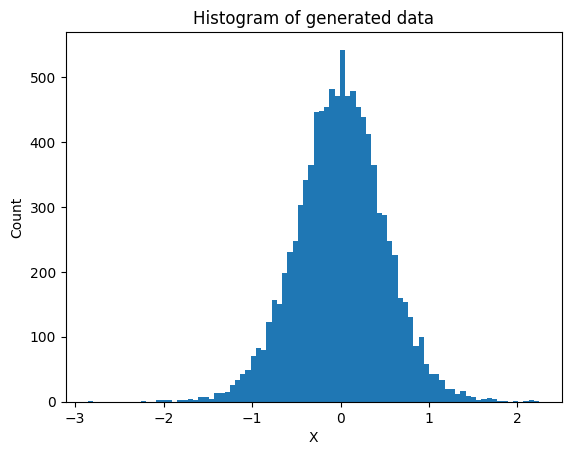

In [7]:
plt.hist(np.array(X_train).flatten(), bins = 'auto')
plt.xlabel("X")
plt.ylabel("Count")
plt.title("Histogram of generated data")
plt.show()

In [8]:
variance = np.var(X_train, axis = 1)
np.random.normal(loc = 0, scale = variance)

array([ 0.24602068, -0.51261465, -0.37591251, -0.61162541,  0.14062405,
       -0.05136878, -0.61454003, -0.16220604,  0.12081082,  0.32526041,
        0.20768353, -0.18393707,  0.03932284, -0.09248345,  0.23720463,
        0.16124271,  0.08305567,  0.2698892 , -0.43983136,  0.15166254])

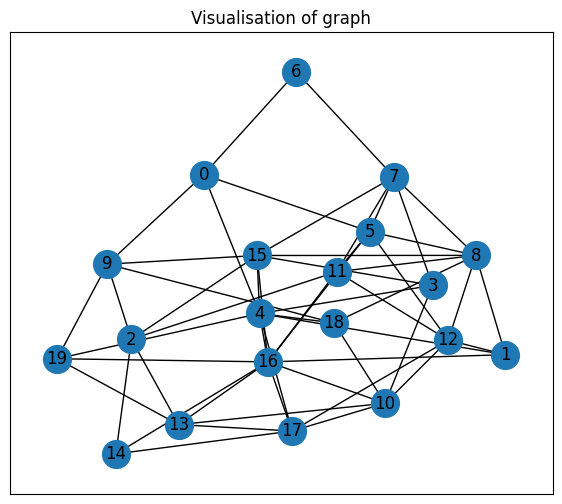

In [9]:
fig = plt.figure(figsize = (7, 6))
rows, cols = np.where(Adj_train == 1)
edges = zip(rows.tolist(), cols.tolist())

gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw_networkx(gr, node_size = 400)

plt.title("Visualisation of graph")
plt.show()

In [10]:
print(N, T)

20 500


In [11]:
dt = np.zeros([T - 1, T])

for i in range(T - 1):
    dt[i, i] = -1
    dt[i, i - 1] = 1

d = dt.T
d = np.concatenate((d, np.zeros([T, 1])), axis = 1) 
d[T - 1, T - 1] = -1
d = d.T
d[T - 1, T - 1] = 1 
d[-1, -2] = 1
d[0, -1] = 0

d = tf.convert_to_tensor(d, dtype = "float32")

print(d)

tf.Tensor(
[[-1.  0.  0. ...  0.  0.  0.]
 [ 1. -1.  0. ...  0.  0.  0.]
 [ 0.  1. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  1. -1.  0.]
 [ 0.  0.  0. ...  0.  1.  1.]], shape=(500, 500), dtype=float32)


In [12]:
Mul = np.eye(N) - np.ones([N, N])
Mul = tf.convert_to_tensor(Mul, dtype = "float32")

In [13]:
def adj_to_laplacian(AdjL):
    tmp = np.array(AdjL, dtype = "float32")
    return np.diag(np.sum(tmp, axis = 0)) - tmp

In [14]:
def initial_graph(X_training, N, top_values):
    distance_matrix = cdist(X_training, X_training, metric = 'euclidean')
    
    sorted_indices = distance_matrix.argsort(1)
    TAdj = np.zeros([N, N])
    
    for i in range(N):
        for j in range(1, top_values):
            k = sorted_indices[i][j]
            TAdj[i][k] = 1
    
    TAdj = (TAdj + TAdj.T) / 2
    TAdj = np.where(TAdj > 0.1, 1, 0)
    
    Laplacian_init = np.diag(np.sum(TAdj, 1)) - TAdj
    
    return Laplacian_init

In [15]:
coeffs = 0
psi_cost = 0
Laplacian = 0
A_transform_cost = 0

model_pred = []
loss_model = []
learned_graph = []
mse_known_list = []
mse_unknown_list = []

In [16]:
coeffs_list = np.load("./Outputs/SNR_cost_func_coeffs.npy")
print(len(coeffs_list))

61


In [17]:
# A - Target, B - Predicted
def costfunc(A, B):
    global coeffs
    global X_train
    global psi_cost
    global Laplacian
    global A_transform_cost

    B_tmp = tf.squeeze(B)
    data_fidelity = (tf.norm(tf.multiply(psi_cost, (X_train - B))) ** 2) * coeffs[0]
    smoothness = tf.linalg.trace(tf.transpose(B_tmp) @ Laplacian @ B_tmp @ A_transform_cost) * coeffs[1]
    L_cost = (tf.norm(Laplacian) ** 2) * coeffs[2]
    Z_cost = (tf.norm(A_transform_cost) ** 2) * coeffs[3]
    
    tmp = (smoothness) + (data_fidelity) + (L_cost) + (Z_cost)
    
    global loss_model
    loss_model.append(tmp)
    
    return tmp
    
def costfunc1(A, B):
    global X_train
    global psi_cost
    
    data_fidelity = (tf.norm(tf.multiply(psi_cost, (X_train - B))) ** 2)
    return (data_fidelity)

def costfunc2(A, B):
    global Laplacian
    global A_transform_cost
    
    B_tmp = tf.squeeze(B)
    smoothness = tf.linalg.trace(tf.transpose(B_tmp) @ Laplacian @ B_tmp @ A_transform_cost)
    
    return (smoothness)

def costfunc3(A, B):
    global Laplacian
    
    L_cost = (tf.norm(Laplacian) ** 2)
    
    return (L_cost)

def costfunc4(A, B):
    global A_transform_cost
    
    Z_cost = (tf.norm(A_transform_cost) ** 2)
    
    return (Z_cost)

In [18]:
def mse_unknown(A, B):
    
    global psi_cost
    psi = psi_cost
    
    psid = tf.convert_to_tensor(np.ones([N, T], dtype = float) - psi, dtype = "float32")
    mse_unk = (LA.norm(np.multiply(psid, (X_train - B))) ** 2) / np.sum(psid.numpy().flatten())
    
    global mse_unknown_list
    mse_unknown_list.append(mse_unk)
    
    return mse_unk

def mse_known(A, B):
    
    global psi_cost
    psi = psi_cost
    
    mse_kn = (LA.norm(np.multiply(psi, (X_train - B))) ** 2) / np.sum(psi.numpy().flatten())
    
    global model_pred
    model_pred.append([A.numpy(), B.numpy()])
    
    global mse_known_list
    mse_known_list.append(mse_kn)
    
    return mse_kn

In [19]:
callb = EarlyStopping(monitor = 'loss', mode = 'min', min_delta = 0.0001, verbose = 1, patience = 10)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr / lr_decay_factor

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [20]:
class ProposedModel(tf.keras.Model):
    
    def __init__(self, L_init, reg_init, loops_init, d_init, p_init, alpha_init, beta_init, threshold_in, **kwargs):
        super(ProposedModel, self).__init__(**kwargs)
        
        self.p1_init = tf.constant(p_init[0], shape = (1, 1), dtype = "float32")
        self.p1 = tf.Variable(initial_value = self.p1_init, trainable = True, name = "p1")
        
        self.p2_init = tf.constant(p_init[1], shape = (1, 1), dtype = "float32")
        self.p2 = tf.Variable(initial_value = self.p2_init, trainable = True, name = "p2")
        
        self.L_in = L_init
        self.preg = reg_init
        self.loops = loops_init
        self.d_int = d_init
        self.alp = alpha_init
        self.bet = beta_init
        self.threshold_init = threshold_in
        
    def data_inpainting(self, psi, Y, Lk, AAT):
        loop_b, reg = self.loops[1], self.preg

        Xk = tf.zeros_like(Y)
        Zk = -(tf.multiply(psi, Xk) - Y + (2 * reg * (Lk @ Xk @ AAT)))
        
        for i in range(loop_b):
            fdx_xk = tf.multiply(psi, Xk) - Y + (2 * reg * (Lk @ Xk @ AAT))

            # row_print = 4
            # tmp = list(zip((tf.multiply(psi, Xk) - Y)[:, row_print].numpy(), (2 * reg * (Lk @ Xk @ AAT)[:, row_print].numpy())))
            # print("\n\nStart here")
            # for k in tmp:
            #     print(k)
            
            fdx_zk = tf.multiply(psi, Zk) - Y + (2 * reg * (Lk @ Zk @ AAT))
            
            tau = tf.linalg.trace(tf.transpose(fdx_xk) @ Zk) / tf.linalg.trace(tf.transpose((Y + fdx_zk)) @ Zk)
            
            Xk_1 = Xk - (tau * Zk)

            fdx_xk_1 = tf.multiply(psi, Xk_1) - Y + (2 * reg * (Lk @ Xk_1 @ AAT))
            gamma = (tf.norm(fdx_xk_1) ** 2) / (tf.norm(fdx_xk) ** 2)

            Zk_1 = (gamma * Zk) - fdx_xk_1

            Xk = Xk_1
            Zk = Zk_1
        # print("\n\nEnds here\n\n")
        return Xk_1
    
    # def graph_learning(self, X, Lk, AAT):
    #     loop_c, alpha, beta = self.loops[2], self.alp, self.bet
        
    #     X_AAT_XT = tf.matmul(X, tf.matmul(AAT, tf.transpose(X)))
    #     # print(AAT)
    #     # print(X_AAT_XT)
        
    #     for i in range(loop_c):
    #         fdL_Lk = coeffs[1] * X_AAT_XT + (beta * Lk)

    #         ###### This is required
    #         # fdx_Lk = tf.transpose(tf.transpose(fdL_Lk) - tf.reduce_mean(fdL_Lk, 1))
    #         fdL_Lk = fdL_Lk - tf.reshape(tf.reduce_mean(fdL_Lk, 1), [N, 1])
    #         fdL_Lk = (fdL_Lk + tf.transpose(fdL_Lk)) / 2
    #         ######
    #         print(np.sum(fdL_Lk.numpy(), axis = 0), np.sum(fdL_Lk.numpy(), axis = 1))
            
    #         Lk_1 = Lk - (alpha * fdL_Lk)
            
    #         ######
    #         Adj_k1 = tf.multiply(Mul, Lk_1)
    #         Adj_k1 = tf.nn.relu(Adj_k1)
    #         Lk_1 = tf.linalg.diag(tf.math.reduce_sum(Adj_k1, 1)) - Adj_k1
    #         ######
            
    #         Lk = Lk_1
    #     return Lk
    
    def graph_learning(self, X, Lk, AAT):
        loop_c, alpha, beta = self.loops[2], self.alp, self.bet
        
        # Computing the smoothness term
        X_AAT_XT = tf.matmul(X, tf.matmul(AAT, tf.transpose(X)))
        
        for i in range(loop_c):

            # Extracting the adjacency matrix from the Laplacian
            adj_i = tf.multiply(Mul, Lk)

            # Computing the gradient with respect to laplacian
            fdL_Lk = X_AAT_XT + (beta * Lk)
            
            # row_print = 4
            # print("For beta")
            # tmp = list(zip(X_AAT_XT[row_print, :].numpy(), np.array(beta * Lk)[row_print, :]))
            # for k in tmp:
            #     print(k)
            
            # Extracting the adjacency matrix from the gradient
            adj_grad = tf.multiply(Mul, fdL_Lk)
            
            # Computing the new adjacency
            # tmp = list(zip(adj_i[row_print, :].numpy(), (alpha * adj_grad)[row_print, :].numpy()))
            # print("\nFor alpha")
            # for k in tmp:
            #     print(k)
            # print("\nStart here")
            
            adj_i1 = adj_i - (alpha * adj_grad)
            
            # Avoiding any negative values
            adj_i1 = tf.nn.relu(adj_i1)

            # Computing the new laplacian
            Lk_1 = tf.linalg.diag(tf.math.reduce_sum(adj_i1, 1)) - adj_i1
            
            # Updating the laplacian
            Lk = Lk_1
        # print("\n\nEnds here\n\n")
        return Lk
    

    def call(self, y):

        psi = y[0,:,T:]
        global psi_cost
        psi_cost = psi

        psi = tf.convert_to_tensor(psi, dtype = "float32")
        
        X_in = y[0,:,:T]
        X_in = psi * tf.convert_to_tensor(X_in, dtype = "float32")
        Y = X_in
        
        d = self.d_int
        LT = tf.matmul(d, tf.transpose(d))
        LT = tf.convert_to_tensor(LT, dtype = "float32")
        
        A_transform = tf.eye(T) + (self.p1 * MP(LT, 1)) + (self.p2 * MP(LT, 2))
        AAT = A_transform
        
        global A_transform_cost
        A_transform_cost = AAT
        
        loop_a = self.loops[0]
        threshold = self.threshold_init
        Lk = self.L_in
        
        for i in range(loop_a):
            
            Xk_1 = self.data_inpainting(psi, Y, Lk, AAT)
            
            Xk_1_gt = X_in + tf.multiply((tf.ones(psi.shape) - psi), Xk_1)
            
            Lk_1 = self.graph_learning(Xk_1_gt, Lk, AAT)
            
            Adj = tf.linalg.diag(tf.linalg.diag_part(Lk_1)) - Lk_1 # Gives adjacency
            
            n = tf.math.count_nonzero(Adj, dtype="float32")
            mean = tf.math.reduce_sum(Adj) / n
            Adj = tf.math.subtract(Adj, (threshold * mean)) # Ensures the sparsity of learned graph
            
            Adj = tf.nn.relu(Adj)
            # Adj = tf.math.sign(Adj)
            
            Lk_1 = tf.linalg.diag(tf.math.reduce_sum(Adj, 1)) - Adj
            
            Lk = Lk_1
        
            global Laplacian
            Laplacian = Lk
        
        Xk_1 = self.data_inpainting(psi, Y, Lk, AAT)
        
        global learned_graph
        learned_graph.append(Lk.numpy())
        
        return tf.reshape(Xk_1, [1, N, T])

In [21]:
Lap_init = initial_graph(X_train, N, 8)

loop_a = 5
loop_b = 10 # Data Inpainting
loop_c = 10 # Graph Learning

reg_init = 1.0e-4

alpha_init = 1.0e-3
beta_init = 1.0e1

threshold_init = 0.3

no_of_psi = 10
sensing_ratio = np.array([0.10])

# SNR_list = [-20.0, -10.0, -5.0, 0.0, 5.0, 10.0, 15.0, 20.0, 30.0, 40.0]
SNR_list = np.arange(0.0, 60.1, 1.0)

p_init = [10.0, 10.0]
lr_decay_factor = 1.1

all_psi = []
all_vars = []

length = no_of_psi * N * T
X_train_variance = np.var(X_train.flatten())

In [22]:
for i_sen, rem in enumerate(sensing_ratio):
    
    print(f"################################### Sensing Ratio: {rem * 100}% ###################################")
    
    X_train_missing = np.zeros([no_of_psi, N, T])
    X_train_concatenated = np.zeros([no_of_psi, N, 2 * T])
    
    if i_sen == 0:
        M = int(rem * T)
        for i in range(no_of_psi):
            psi_k = np.array([0] * (N * M) + [1] * (N * (T - M)))
            np.random.shuffle(psi_k)
            psi_k = psi_k.reshape([N, T])
            all_psi.append(psi_k)
            X_train_missing[i, : , : ] = X_train * psi_k
            X_train_concatenated[i, :, :] = np.concatenate((X_train_missing[i], psi_k), axis = 1)

    else:
        previous_psi = all_psi[-no_of_psi : ]
        
        rem_diff = int(N * (rem - sensing_ratio[i_sen - 1]) * T)
        
        for i in range(no_of_psi):
            psi_k_tmp = np.array(previous_psi[i]).flatten()
            ones_idx = np.where(psi_k_tmp == 1)
            
            ones_to_zero_idx = np.random.choice(ones_idx[0], size = rem_diff)
            psi_k_tmp[ones_to_zero_idx] = 0
            psi_k = psi_k_tmp
            
            psi_k = psi_k.reshape([N, T])
            all_psi.append(psi_k)
            X_train_missing[i, : , : ] = X_train * psi_k
            X_train_concatenated[i, :, :] = np.concatenate((X_train_missing[i], psi_k), axis = 1)
    
    for i_snr, snr_in_dB in enumerate(SNR_list):
        print(f"\n\n######################################################################")
        print(f"############################ SNR: {snr_in_dB} dB ###########################")
        print(f"######################################################################\n\n")
        
        coeffs = coeffs_list[i_snr, :]
        
        sgd_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.0)
        
        our_model = ProposedModel(Lap_init, reg_init, [loop_a, loop_b, loop_c], 
                                  d, p_init, alpha_init, beta_init, threshold_init, name = 'our')
        our_model.compile(optimizer = sgd_optimizer, loss = costfunc,
                          metrics = [mse_known, mse_unknown], run_eagerly=True)
        
        # Adding noise to data
        snr = 10 ** (-snr_in_dB / 10)
                
        noise_matrix = np.random.normal(loc = 0.0, 
                                        scale = np.sqrt(snr * X_train_variance),
                                       size = length).reshape([no_of_psi, N, T])
        
        X_train_concatenated_noisy = np.copy(X_train_concatenated)
        X_train_concatenated_noisy[:, :, : T] += noise_matrix
        
        our_model.fit(X_train_concatenated_noisy, X_train_missing, epochs = 20, 
                      callbacks = [lr_scheduler], batch_size = 1)

        var = our_model.variables
        var_lst = []
        for v in var:
            var_lst.append(v.numpy()[0, 0])
        print(f"\nFilter Coefficients:", var_lst)
        all_vars.append(var_lst)

################################### Sensing Ratio: 10.0% ###################################


######################################################################
############################ SNR: 0.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 612ms/step - loss: 58.7312 - mse_known: 0.1247 - mse_unknown: 0.2032 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 7s 668ms/step - loss: 51.0322 - mse_known: 0.1280 - mse_unknown: 0.2088 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 7s 668ms/step - loss: 44.4059 - mse_known: 0.1316 - mse_unknown: 0.2145 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 617ms/step - loss: 38.7009 - mse_known: 0.1354 - mse_unknown: 0.2198 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 627ms/step - loss: 33.7849 - mse_known: 0.1394 - mse_unknown: 0.2254 - lr: 0.0100
Epoch 6


Filter Coefficients: [7.4751205, 1.4720151]


######################################################################
############################ SNR: 1.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 615ms/step - loss: 58.0791 - mse_known: 0.1058 - mse_unknown: 0.1892 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 608ms/step - loss: 50.3487 - mse_known: 0.1084 - mse_unknown: 0.1939 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 608ms/step - loss: 43.6950 - mse_known: 0.1113 - mse_unknown: 0.1985 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 614ms/step - loss: 37.9643 - mse_known: 0.1143 - mse_unknown: 0.2034 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 621ms/step - loss: 33.0265 - mse_known: 0.1175 - mse_unknown: 0.2083 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.4811697, 1.4724004]


######################################################################
############################ SNR: 2.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 601ms/step - loss: 64.8647 - mse_known: 0.0898 - mse_unknown: 0.1737 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 608ms/step - loss: 57.4168 - mse_known: 0.0918 - mse_unknown: 0.1772 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 609ms/step - loss: 51.0510 - mse_known: 0.0939 - mse_unknown: 0.1807 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 600ms/step - loss: 45.6119 - mse_known: 0.0962 - mse_unknown: 0.1842 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 606ms/step - loss: 40.9714 - mse_known: 0.0986 - mse_unknown: 0.1882 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.6694775, 1.8755025]


######################################################################
############################ SNR: 3.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 631ms/step - loss: 63.2348 - mse_known: 0.0753 - mse_unknown: 0.1579 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 619ms/step - loss: 55.7067 - mse_known: 0.0769 - mse_unknown: 0.1613 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 627ms/step - loss: 49.2637 - mse_known: 0.0786 - mse_unknown: 0.1647 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 619ms/step - loss: 43.7482 - mse_known: 0.0804 - mse_unknown: 0.1683 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 621ms/step - loss: 39.0307 - mse_known: 0.0822 - mse_unknown: 0.1718 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.6279917, 1.7851831]


######################################################################
############################ SNR: 4.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 628ms/step - loss: 61.8087 - mse_known: 0.0624 - mse_unknown: 0.1515 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 604ms/step - loss: 54.2073 - mse_known: 0.0635 - mse_unknown: 0.1543 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 615ms/step - loss: 47.6926 - mse_known: 0.0647 - mse_unknown: 0.1572 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 604ms/step - loss: 42.1139 - mse_known: 0.0660 - mse_unknown: 0.1603 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 605ms/step - loss: 37.3389 - mse_known: 0.0674 - mse_unknown: 0.1632 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.5990405, 1.7162136]


######################################################################
############################ SNR: 5.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 600ms/step - loss: 60.8161 - mse_known: 0.0529 - mse_unknown: 0.1385 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 605ms/step - loss: 53.1510 - mse_known: 0.0538 - mse_unknown: 0.1405 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 622ms/step - loss: 46.5764 - mse_known: 0.0547 - mse_unknown: 0.1427 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 611ms/step - loss: 40.9402 - mse_known: 0.0557 - mse_unknown: 0.1451 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 603ms/step - loss: 36.1088 - mse_known: 0.0566 - mse_unknown: 0.1473 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.5728526, 1.6532272]


######################################################################
############################ SNR: 6.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 7s 659ms/step - loss: 59.8537 - mse_known: 0.0442 - mse_unknown: 0.1272 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 620ms/step - loss: 52.1486 - mse_known: 0.0447 - mse_unknown: 0.1289 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 617ms/step - loss: 45.5366 - mse_known: 0.0454 - mse_unknown: 0.1308 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 616ms/step - loss: 39.8633 - mse_known: 0.0460 - mse_unknown: 0.1328 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 619ms/step - loss: 34.9976 - mse_known: 0.0467 - mse_unknown: 0.1349 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.5554786, 1.6151204]


######################################################################
############################ SNR: 7.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 606ms/step - loss: 59.0294 - mse_known: 0.0367 - mse_unknown: 0.1210 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 597ms/step - loss: 51.2969 - mse_known: 0.0371 - mse_unknown: 0.1225 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 613ms/step - loss: 44.6594 - mse_known: 0.0375 - mse_unknown: 0.1241 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 628ms/step - loss: 38.9638 - mse_known: 0.0379 - mse_unknown: 0.1257 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 610ms/step - loss: 34.0783 - mse_known: 0.0384 - mse_unknown: 0.1272 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.5452538, 1.5902306]


######################################################################
############################ SNR: 8.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 643ms/step - loss: 58.3522 - mse_known: 0.0302 - mse_unknown: 0.1111 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 7s 687ms/step - loss: 50.5921 - mse_known: 0.0304 - mse_unknown: 0.1123 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 7s 688ms/step - loss: 43.9289 - mse_known: 0.0306 - mse_unknown: 0.1137 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 7s 715ms/step - loss: 38.2094 - mse_known: 0.0308 - mse_unknown: 0.1151 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 7s 685ms/step - loss: 33.3011 - mse_known: 0.0311 - mse_unknown: 0.1164 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 7s 


Filter Coefficients: [7.534081, 1.5675329]


######################################################################
############################ SNR: 9.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 617ms/step - loss: 57.8265 - mse_known: 0.0254 - mse_unknown: 0.1067 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 618ms/step - loss: 50.0539 - mse_known: 0.0254 - mse_unknown: 0.1078 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 615ms/step - loss: 43.3794 - mse_known: 0.0255 - mse_unknown: 0.1088 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 624ms/step - loss: 37.6488 - mse_known: 0.0256 - mse_unknown: 0.1099 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 624ms/step - loss: 32.7298 - mse_known: 0.0258 - mse_unknown: 0.1108 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 6


Filter Coefficients: [7.52812, 1.5549875]


######################################################################
############################ SNR: 10.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 621ms/step - loss: 57.3778 - mse_known: 0.0211 - mse_unknown: 0.1050 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 650ms/step - loss: 49.5898 - mse_known: 0.0210 - mse_unknown: 0.1060 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 7s 655ms/step - loss: 42.9015 - mse_known: 0.0210 - mse_unknown: 0.1072 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 626ms/step - loss: 37.1582 - mse_known: 0.0210 - mse_unknown: 0.1083 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 619ms/step - loss: 32.2275 - mse_known: 0.0211 - mse_unknown: 0.1092 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 6


Filter Coefficients: [7.5229664, 1.5435642]


######################################################################
############################ SNR: 11.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 627ms/step - loss: 57.0075 - mse_known: 0.0175 - mse_unknown: 0.1013 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 619ms/step - loss: 49.2108 - mse_known: 0.0174 - mse_unknown: 0.1021 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 613ms/step - loss: 42.5134 - mse_known: 0.0173 - mse_unknown: 0.1030 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 619ms/step - loss: 36.7614 - mse_known: 0.0172 - mse_unknown: 0.1039 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 615ms/step - loss: 31.8229 - mse_known: 0.0172 - mse_unknown: 0.1046 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s


Filter Coefficients: [7.5193214, 1.5358382]


######################################################################
############################ SNR: 12.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 626ms/step - loss: 56.7064 - mse_known: 0.0146 - mse_unknown: 0.0960 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 615ms/step - loss: 48.9030 - mse_known: 0.0144 - mse_unknown: 0.0966 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 626ms/step - loss: 42.2004 - mse_known: 0.0143 - mse_unknown: 0.0973 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 617ms/step - loss: 36.4433 - mse_known: 0.0141 - mse_unknown: 0.0979 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 618ms/step - loss: 31.4995 - mse_known: 0.0141 - mse_unknown: 0.0985 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s


Filter Coefficients: [7.515937, 1.5300362]


######################################################################
############################ SNR: 13.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 601ms/step - loss: 56.4696 - mse_known: 0.0123 - mse_unknown: 0.0941 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 603ms/step - loss: 48.6598 - mse_known: 0.0121 - mse_unknown: 0.0946 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 617ms/step - loss: 41.9510 - mse_known: 0.0119 - mse_unknown: 0.0951 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 604ms/step - loss: 36.1894 - mse_known: 0.0117 - mse_unknown: 0.0955 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 609ms/step - loss: 31.2416 - mse_known: 0.0116 - mse_unknown: 0.0959 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.513912, 1.5259298]


######################################################################
############################ SNR: 14.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 627ms/step - loss: 56.2890 - mse_known: 0.0106 - mse_unknown: 0.0923 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 619ms/step - loss: 48.4750 - mse_known: 0.0103 - mse_unknown: 0.0928 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 620ms/step - loss: 41.7622 - mse_known: 0.0100 - mse_unknown: 0.0933 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 619ms/step - loss: 35.9964 - mse_known: 0.0098 - mse_unknown: 0.0938 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 627ms/step - loss: 31.0438 - mse_known: 0.0096 - mse_unknown: 0.0944 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.511578, 1.5216658]


######################################################################
############################ SNR: 15.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 619ms/step - loss: 56.1551 - mse_known: 0.0092 - mse_unknown: 0.0903 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 635ms/step - loss: 48.3352 - mse_known: 0.0089 - mse_unknown: 0.0905 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 615ms/step - loss: 41.6168 - mse_known: 0.0086 - mse_unknown: 0.0910 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 614ms/step - loss: 35.8463 - mse_known: 0.0084 - mse_unknown: 0.0915 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 616ms/step - loss: 30.8889 - mse_known: 0.0081 - mse_unknown: 0.0920 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.5096292, 1.5179458]


######################################################################
############################ SNR: 16.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 7s 731ms/step - loss: 56.0324 - mse_known: 0.0080 - mse_unknown: 0.0903 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 7s 675ms/step - loss: 48.2106 - mse_known: 0.0077 - mse_unknown: 0.0905 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 7s 687ms/step - loss: 41.4900 - mse_known: 0.0074 - mse_unknown: 0.0910 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 7s 672ms/step - loss: 35.7168 - mse_known: 0.0071 - mse_unknown: 0.0915 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 7s 673ms/step - loss: 30.7581 - mse_known: 0.0069 - mse_unknown: 0.0920 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 7s


Filter Coefficients: [7.5085273, 1.5161817]


######################################################################
############################ SNR: 17.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 638ms/step - loss: 61.4546 - mse_known: 0.0070 - mse_unknown: 0.0885 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 628ms/step - loss: 53.0782 - mse_known: 0.0066 - mse_unknown: 0.0888 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 643ms/step - loss: 45.9093 - mse_known: 0.0063 - mse_unknown: 0.0893 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 610ms/step - loss: 39.7794 - mse_known: 0.0060 - mse_unknown: 0.0899 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 613ms/step - loss: 34.5433 - mse_known: 0.0058 - mse_unknown: 0.0904 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s


Filter Coefficients: [7.431713, 1.4025607]


######################################################################
############################ SNR: 18.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 621ms/step - loss: 60.8122 - mse_known: 0.0063 - mse_unknown: 0.0882 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 626ms/step - loss: 52.4024 - mse_known: 0.0059 - mse_unknown: 0.0884 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 614ms/step - loss: 45.2037 - mse_known: 0.0056 - mse_unknown: 0.0889 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 608ms/step - loss: 39.0437 - mse_known: 0.0052 - mse_unknown: 0.0895 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 601ms/step - loss: 33.7839 - mse_known: 0.0050 - mse_unknown: 0.0899 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.420012, 1.3808842]


######################################################################
############################ SNR: 19.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 614ms/step - loss: 60.1769 - mse_known: 0.0056 - mse_unknown: 0.0868 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 625ms/step - loss: 51.7711 - mse_known: 0.0052 - mse_unknown: 0.0871 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 620ms/step - loss: 44.5745 - mse_known: 0.0049 - mse_unknown: 0.0875 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 609ms/step - loss: 38.4161 - mse_known: 0.0046 - mse_unknown: 0.0880 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 642ms/step - loss: 33.1523 - mse_known: 0.0043 - mse_unknown: 0.0885 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.41389, 1.3729259]


######################################################################
############################ SNR: 20.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 611ms/step - loss: 59.7850 - mse_known: 0.0052 - mse_unknown: 0.0870 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 631ms/step - loss: 51.3521 - mse_known: 0.0048 - mse_unknown: 0.0872 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 604ms/step - loss: 44.1286 - mse_known: 0.0044 - mse_unknown: 0.0877 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 606ms/step - loss: 37.9496 - mse_known: 0.0041 - mse_unknown: 0.0882 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 611ms/step - loss: 32.6672 - mse_known: 0.0038 - mse_unknown: 0.0887 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 6


Filter Coefficients: [7.406109, 1.3606317]


######################################################################
############################ SNR: 21.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 7s 669ms/step - loss: 59.4519 - mse_known: 0.0048 - mse_unknown: 0.0874 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 643ms/step - loss: 51.0026 - mse_known: 0.0044 - mse_unknown: 0.0876 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 642ms/step - loss: 43.7708 - mse_known: 0.0040 - mse_unknown: 0.0880 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 7s 694ms/step - loss: 37.5818 - mse_known: 0.0037 - mse_unknown: 0.0884 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 646ms/step - loss: 32.2875 - mse_known: 0.0034 - mse_unknown: 0.0889 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.4003377, 1.3486506]


######################################################################
############################ SNR: 22.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 631ms/step - loss: 59.1637 - mse_known: 0.0045 - mse_unknown: 0.0864 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 625ms/step - loss: 50.7054 - mse_known: 0.0041 - mse_unknown: 0.0867 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 625ms/step - loss: 43.4618 - mse_known: 0.0037 - mse_unknown: 0.0871 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 629ms/step - loss: 37.2680 - mse_known: 0.0034 - mse_unknown: 0.0876 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 632ms/step - loss: 31.9672 - mse_known: 0.0031 - mse_unknown: 0.0880 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 7s


Filter Coefficients: [7.396165, 1.3426149]


######################################################################
############################ SNR: 23.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 616ms/step - loss: 58.9907 - mse_known: 0.0043 - mse_unknown: 0.0863 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 618ms/step - loss: 50.5178 - mse_known: 0.0039 - mse_unknown: 0.0864 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 616ms/step - loss: 43.2602 - mse_known: 0.0035 - mse_unknown: 0.0868 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 615ms/step - loss: 37.0471 - mse_known: 0.0031 - mse_unknown: 0.0872 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 615ms/step - loss: 31.7348 - mse_known: 0.0028 - mse_unknown: 0.0877 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.39281, 1.3351178]


######################################################################
############################ SNR: 24.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 629ms/step - loss: 58.7845 - mse_known: 0.0041 - mse_unknown: 0.0862 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 610ms/step - loss: 50.3117 - mse_known: 0.0037 - mse_unknown: 0.0863 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 7s 667ms/step - loss: 43.0586 - mse_known: 0.0033 - mse_unknown: 0.0867 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 7s 712ms/step - loss: 36.8436 - mse_known: 0.0029 - mse_unknown: 0.0871 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 7s 658ms/step - loss: 31.5299 - mse_known: 0.0026 - mse_unknown: 0.0875 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 7s 6


Filter Coefficients: [7.3911915, 1.3328451]


######################################################################
############################ SNR: 25.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 7s 675ms/step - loss: 58.6142 - mse_known: 0.0039 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 638ms/step - loss: 50.1409 - mse_known: 0.0035 - mse_unknown: 0.0867 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 650ms/step - loss: 42.8946 - mse_known: 0.0031 - mse_unknown: 0.0871 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 7s 656ms/step - loss: 36.6786 - mse_known: 0.0027 - mse_unknown: 0.0876 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 7s 651ms/step - loss: 31.3689 - mse_known: 0.0024 - mse_unknown: 0.0880 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 7s


Filter Coefficients: [7.39065, 1.3314487]


######################################################################
############################ SNR: 26.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 647ms/step - loss: 58.5292 - mse_known: 0.0038 - mse_unknown: 0.0854 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 7s 662ms/step - loss: 50.0498 - mse_known: 0.0034 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 639ms/step - loss: 42.7842 - mse_known: 0.0030 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 630ms/step - loss: 36.5625 - mse_known: 0.0026 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 635ms/step - loss: 31.2399 - mse_known: 0.0023 - mse_unknown: 0.0870 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 7s 6


Filter Coefficients: [7.38814, 1.3274937]


######################################################################
############################ SNR: 27.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 7s 691ms/step - loss: 58.4052 - mse_known: 0.0037 - mse_unknown: 0.0859 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 7s 653ms/step - loss: 49.9287 - mse_known: 0.0032 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 7s 686ms/step - loss: 42.6669 - mse_known: 0.0028 - mse_unknown: 0.0864 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 622ms/step - loss: 36.4510 - mse_known: 0.0025 - mse_unknown: 0.0868 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 609ms/step - loss: 31.1307 - mse_known: 0.0022 - mse_unknown: 0.0872 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 6


Filter Coefficients: [7.388266, 1.3274426]


######################################################################
############################ SNR: 28.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 641ms/step - loss: 58.3577 - mse_known: 0.0036 - mse_unknown: 0.0854 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 641ms/step - loss: 49.8791 - mse_known: 0.0032 - mse_unknown: 0.0856 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 7s 661ms/step - loss: 42.6155 - mse_known: 0.0028 - mse_unknown: 0.0859 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 7s 666ms/step - loss: 36.3938 - mse_known: 0.0024 - mse_unknown: 0.0864 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 625ms/step - loss: 31.0764 - mse_known: 0.0021 - mse_unknown: 0.0867 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.3859487, 1.3231567]


######################################################################
############################ SNR: 29.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 7s 668ms/step - loss: 58.3075 - mse_known: 0.0036 - mse_unknown: 0.0852 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 7s 676ms/step - loss: 49.8254 - mse_known: 0.0031 - mse_unknown: 0.0854 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 7s 672ms/step - loss: 42.5552 - mse_known: 0.0027 - mse_unknown: 0.0858 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 7s 668ms/step - loss: 36.3310 - mse_known: 0.0024 - mse_unknown: 0.0863 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 7s 672ms/step - loss: 31.0066 - mse_known: 0.0021 - mse_unknown: 0.0867 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 7s


Filter Coefficients: [7.38524, 1.3226455]


######################################################################
############################ SNR: 30.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 7s 675ms/step - loss: 58.2553 - mse_known: 0.0035 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 7s 666ms/step - loss: 49.7717 - mse_known: 0.0031 - mse_unknown: 0.0859 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 7s 679ms/step - loss: 42.5049 - mse_known: 0.0027 - mse_unknown: 0.0863 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 7s 715ms/step - loss: 36.2788 - mse_known: 0.0023 - mse_unknown: 0.0867 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 7s 669ms/step - loss: 30.9497 - mse_known: 0.0020 - mse_unknown: 0.0872 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 7s 6


Filter Coefficients: [7.3850374, 1.322332]


######################################################################
############################ SNR: 31.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 627ms/step - loss: 58.2325 - mse_known: 0.0035 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 639ms/step - loss: 49.7471 - mse_known: 0.0030 - mse_unknown: 0.0858 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 637ms/step - loss: 42.4804 - mse_known: 0.0026 - mse_unknown: 0.0862 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 617ms/step - loss: 36.2541 - mse_known: 0.0023 - mse_unknown: 0.0866 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 639ms/step - loss: 30.9255 - mse_known: 0.0020 - mse_unknown: 0.0870 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.384029, 1.3189304]


######################################################################
############################ SNR: 32.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 628ms/step - loss: 58.1954 - mse_known: 0.0034 - mse_unknown: 0.0855 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 631ms/step - loss: 49.7044 - mse_known: 0.0030 - mse_unknown: 0.0856 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 634ms/step - loss: 42.4383 - mse_known: 0.0026 - mse_unknown: 0.0859 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 622ms/step - loss: 36.2129 - mse_known: 0.0022 - mse_unknown: 0.0863 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 620ms/step - loss: 30.8849 - mse_known: 0.0019 - mse_unknown: 0.0867 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.3839173, 1.320144]


######################################################################
############################ SNR: 33.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 636ms/step - loss: 58.1716 - mse_known: 0.0034 - mse_unknown: 0.0858 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 632ms/step - loss: 49.6859 - mse_known: 0.0030 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 633ms/step - loss: 42.4133 - mse_known: 0.0026 - mse_unknown: 0.0864 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 632ms/step - loss: 36.1855 - mse_known: 0.0022 - mse_unknown: 0.0868 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 622ms/step - loss: 30.8602 - mse_known: 0.0019 - mse_unknown: 0.0872 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.3837886, 1.3190808]


######################################################################
############################ SNR: 34.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 585ms/step - loss: 58.1626 - mse_known: 0.0034 - mse_unknown: 0.0855 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 584ms/step - loss: 49.6749 - mse_known: 0.0030 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 591ms/step - loss: 42.4030 - mse_known: 0.0026 - mse_unknown: 0.0861 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 588ms/step - loss: 36.1745 - mse_known: 0.0022 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 583ms/step - loss: 30.8461 - mse_known: 0.0019 - mse_unknown: 0.0869 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s


Filter Coefficients: [7.383078, 1.3183461]


######################################################################
############################ SNR: 35.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 576ms/step - loss: 58.1212 - mse_known: 0.0034 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 585ms/step - loss: 49.6407 - mse_known: 0.0029 - mse_unknown: 0.0858 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 591ms/step - loss: 42.3762 - mse_known: 0.0025 - mse_unknown: 0.0861 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 579ms/step - loss: 36.1537 - mse_known: 0.0022 - mse_unknown: 0.0866 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 587ms/step - loss: 30.8292 - mse_known: 0.0019 - mse_unknown: 0.0869 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.3834925, 1.3188114]


######################################################################
############################ SNR: 36.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 590ms/step - loss: 58.1310 - mse_known: 0.0034 - mse_unknown: 0.0856 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 582ms/step - loss: 49.6436 - mse_known: 0.0029 - mse_unknown: 0.0858 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 587ms/step - loss: 42.3756 - mse_known: 0.0025 - mse_unknown: 0.0861 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 585ms/step - loss: 36.1454 - mse_known: 0.0022 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 591ms/step - loss: 30.8101 - mse_known: 0.0019 - mse_unknown: 0.0870 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s


Filter Coefficients: [7.38293, 1.318371]


######################################################################
############################ SNR: 37.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 612ms/step - loss: 58.1237 - mse_known: 0.0034 - mse_unknown: 0.0855 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 606ms/step - loss: 49.6300 - mse_known: 0.0029 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 611ms/step - loss: 42.3572 - mse_known: 0.0025 - mse_unknown: 0.0861 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 603ms/step - loss: 36.1312 - mse_known: 0.0022 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 608ms/step - loss: 30.8006 - mse_known: 0.0018 - mse_unknown: 0.0868 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 61


Filter Coefficients: [7.3829074, 1.3181403]


######################################################################
############################ SNR: 38.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 607ms/step - loss: 58.1015 - mse_known: 0.0033 - mse_unknown: 0.0856 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 612ms/step - loss: 49.6130 - mse_known: 0.0029 - mse_unknown: 0.0858 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 601ms/step - loss: 42.3426 - mse_known: 0.0025 - mse_unknown: 0.0862 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 602ms/step - loss: 36.1187 - mse_known: 0.0021 - mse_unknown: 0.0866 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 584ms/step - loss: 30.7911 - mse_known: 0.0018 - mse_unknown: 0.0870 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s


Filter Coefficients: [7.383267, 1.3186587]


######################################################################
############################ SNR: 39.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 582ms/step - loss: 58.1160 - mse_known: 0.0034 - mse_unknown: 0.0854 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 582ms/step - loss: 49.6227 - mse_known: 0.0029 - mse_unknown: 0.0855 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 584ms/step - loss: 42.3443 - mse_known: 0.0025 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 585ms/step - loss: 36.1188 - mse_known: 0.0021 - mse_unknown: 0.0864 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 582ms/step - loss: 30.7887 - mse_known: 0.0018 - mse_unknown: 0.0867 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.382714, 1.3177954]


######################################################################
############################ SNR: 40.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 580ms/step - loss: 58.1061 - mse_known: 0.0033 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 577ms/step - loss: 49.6166 - mse_known: 0.0029 - mse_unknown: 0.0858 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 585ms/step - loss: 42.3457 - mse_known: 0.0025 - mse_unknown: 0.0861 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 580ms/step - loss: 36.1162 - mse_known: 0.0021 - mse_unknown: 0.0866 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 575ms/step - loss: 30.7861 - mse_known: 0.0018 - mse_unknown: 0.0870 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.3825955, 1.3175411]


######################################################################
############################ SNR: 41.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 579ms/step - loss: 58.1022 - mse_known: 0.0033 - mse_unknown: 0.0855 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 580ms/step - loss: 49.6135 - mse_known: 0.0029 - mse_unknown: 0.0856 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 584ms/step - loss: 42.3391 - mse_known: 0.0025 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 587ms/step - loss: 36.1081 - mse_known: 0.0021 - mse_unknown: 0.0864 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 580ms/step - loss: 30.7800 - mse_known: 0.0018 - mse_unknown: 0.0868 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s


Filter Coefficients: [7.3825006, 1.3176636]


######################################################################
############################ SNR: 42.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 587ms/step - loss: 58.0945 - mse_known: 0.0033 - mse_unknown: 0.0855 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 584ms/step - loss: 49.6069 - mse_known: 0.0029 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 580ms/step - loss: 42.3358 - mse_known: 0.0025 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 590ms/step - loss: 36.1100 - mse_known: 0.0021 - mse_unknown: 0.0864 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 579ms/step - loss: 30.7762 - mse_known: 0.0018 - mse_unknown: 0.0868 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s


Filter Coefficients: [7.3826756, 1.3178107]


######################################################################
############################ SNR: 43.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 586ms/step - loss: 58.0948 - mse_known: 0.0033 - mse_unknown: 0.0856 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 588ms/step - loss: 49.6044 - mse_known: 0.0029 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 582ms/step - loss: 42.3326 - mse_known: 0.0025 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 590ms/step - loss: 36.1030 - mse_known: 0.0021 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 587ms/step - loss: 30.7732 - mse_known: 0.0018 - mse_unknown: 0.0869 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s


Filter Coefficients: [7.3826323, 1.3176008]


######################################################################
############################ SNR: 44.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 585ms/step - loss: 58.0901 - mse_known: 0.0033 - mse_unknown: 0.0856 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 579ms/step - loss: 49.6047 - mse_known: 0.0029 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 586ms/step - loss: 42.3300 - mse_known: 0.0025 - mse_unknown: 0.0861 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 591ms/step - loss: 36.1014 - mse_known: 0.0021 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 586ms/step - loss: 30.7723 - mse_known: 0.0018 - mse_unknown: 0.0869 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s


Filter Coefficients: [7.3825464, 1.317553]


######################################################################
############################ SNR: 45.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 584ms/step - loss: 58.0841 - mse_known: 0.0033 - mse_unknown: 0.0855 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 582ms/step - loss: 49.5979 - mse_known: 0.0029 - mse_unknown: 0.0856 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 590ms/step - loss: 42.3265 - mse_known: 0.0025 - mse_unknown: 0.0859 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 586ms/step - loss: 36.0953 - mse_known: 0.0021 - mse_unknown: 0.0864 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 581ms/step - loss: 30.7687 - mse_known: 0.0018 - mse_unknown: 0.0868 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.382762, 1.3178775]


######################################################################
############################ SNR: 46.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 584ms/step - loss: 58.0872 - mse_known: 0.0033 - mse_unknown: 0.0856 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 582ms/step - loss: 49.6003 - mse_known: 0.0029 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 587ms/step - loss: 42.3264 - mse_known: 0.0025 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 595ms/step - loss: 36.0952 - mse_known: 0.0021 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 591ms/step - loss: 30.7670 - mse_known: 0.0018 - mse_unknown: 0.0869 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.382646, 1.3176264]


######################################################################
############################ SNR: 47.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 583ms/step - loss: 58.0863 - mse_known: 0.0033 - mse_unknown: 0.0855 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 587ms/step - loss: 49.5995 - mse_known: 0.0029 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 587ms/step - loss: 42.3261 - mse_known: 0.0025 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 591ms/step - loss: 36.0944 - mse_known: 0.0021 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 583ms/step - loss: 30.7667 - mse_known: 0.0018 - mse_unknown: 0.0869 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.3826036, 1.3175012]


######################################################################
############################ SNR: 48.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 585ms/step - loss: 58.0864 - mse_known: 0.0033 - mse_unknown: 0.0856 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 586ms/step - loss: 49.6003 - mse_known: 0.0029 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 578ms/step - loss: 42.3260 - mse_known: 0.0025 - mse_unknown: 0.0861 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 579ms/step - loss: 36.0961 - mse_known: 0.0021 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 592ms/step - loss: 30.7666 - mse_known: 0.0018 - mse_unknown: 0.0869 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s


Filter Coefficients: [7.382532, 1.3174301]


######################################################################
############################ SNR: 49.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 591ms/step - loss: 58.0887 - mse_known: 0.0033 - mse_unknown: 0.0856 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 581ms/step - loss: 49.6012 - mse_known: 0.0029 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 584ms/step - loss: 42.3272 - mse_known: 0.0025 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 585ms/step - loss: 36.0940 - mse_known: 0.0021 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 585ms/step - loss: 30.7639 - mse_known: 0.0018 - mse_unknown: 0.0870 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.3825316, 1.3174686]


######################################################################
############################ SNR: 50.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 608ms/step - loss: 58.0835 - mse_known: 0.0033 - mse_unknown: 0.0856 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 604ms/step - loss: 49.5971 - mse_known: 0.0029 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 608ms/step - loss: 42.3193 - mse_known: 0.0025 - mse_unknown: 0.0861 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 608ms/step - loss: 36.0933 - mse_known: 0.0021 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 610ms/step - loss: 30.7633 - mse_known: 0.0018 - mse_unknown: 0.0869 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s


Filter Coefficients: [7.382586, 1.3175782]


######################################################################
############################ SNR: 51.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 604ms/step - loss: 58.0825 - mse_known: 0.0033 - mse_unknown: 0.0855 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 584ms/step - loss: 49.5975 - mse_known: 0.0029 - mse_unknown: 0.0856 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 590ms/step - loss: 42.3235 - mse_known: 0.0025 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 585ms/step - loss: 36.0940 - mse_known: 0.0021 - mse_unknown: 0.0864 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 585ms/step - loss: 30.7650 - mse_known: 0.0018 - mse_unknown: 0.0868 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.3826685, 1.3176941]


######################################################################
############################ SNR: 52.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 585ms/step - loss: 58.0812 - mse_known: 0.0033 - mse_unknown: 0.0856 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 579ms/step - loss: 49.5969 - mse_known: 0.0029 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 596ms/step - loss: 42.3231 - mse_known: 0.0025 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 589ms/step - loss: 36.0940 - mse_known: 0.0021 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 585ms/step - loss: 30.7633 - mse_known: 0.0018 - mse_unknown: 0.0869 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s


Filter Coefficients: [7.3825283, 1.3174537]


######################################################################
############################ SNR: 53.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 581ms/step - loss: 58.0846 - mse_known: 0.0033 - mse_unknown: 0.0855 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 581ms/step - loss: 49.5964 - mse_known: 0.0029 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 590ms/step - loss: 42.3226 - mse_known: 0.0025 - mse_unknown: 0.0861 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 586ms/step - loss: 36.0918 - mse_known: 0.0021 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 585ms/step - loss: 30.7624 - mse_known: 0.0018 - mse_unknown: 0.0869 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s


Filter Coefficients: [7.3826237, 1.3176531]


######################################################################
############################ SNR: 54.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 582ms/step - loss: 58.0805 - mse_known: 0.0033 - mse_unknown: 0.0856 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 583ms/step - loss: 49.5967 - mse_known: 0.0029 - mse_unknown: 0.0856 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 593ms/step - loss: 42.3213 - mse_known: 0.0025 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 584ms/step - loss: 36.0908 - mse_known: 0.0021 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 584ms/step - loss: 30.7625 - mse_known: 0.0018 - mse_unknown: 0.0869 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s


Filter Coefficients: [7.3826437, 1.317544]


######################################################################
############################ SNR: 55.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 583ms/step - loss: 58.0849 - mse_known: 0.0033 - mse_unknown: 0.0855 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 592ms/step - loss: 49.5978 - mse_known: 0.0029 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 588ms/step - loss: 42.3231 - mse_known: 0.0025 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 589ms/step - loss: 36.0905 - mse_known: 0.0021 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 588ms/step - loss: 30.7646 - mse_known: 0.0018 - mse_unknown: 0.0868 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.382573, 1.3175312]


######################################################################
############################ SNR: 56.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 588ms/step - loss: 58.0866 - mse_known: 0.0033 - mse_unknown: 0.0855 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 592ms/step - loss: 49.5954 - mse_known: 0.0029 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 583ms/step - loss: 42.3201 - mse_known: 0.0025 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 590ms/step - loss: 36.0906 - mse_known: 0.0021 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 596ms/step - loss: 30.7621 - mse_known: 0.0018 - mse_unknown: 0.0869 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 


Filter Coefficients: [7.38264, 1.3176409]


######################################################################
############################ SNR: 57.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 592ms/step - loss: 58.0831 - mse_known: 0.0033 - mse_unknown: 0.0855 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 588ms/step - loss: 49.5955 - mse_known: 0.0029 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 585ms/step - loss: 42.3243 - mse_known: 0.0025 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 587ms/step - loss: 36.0920 - mse_known: 0.0021 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 587ms/step - loss: 30.7625 - mse_known: 0.0018 - mse_unknown: 0.0869 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 5


Filter Coefficients: [7.38264, 1.3176295]


######################################################################
############################ SNR: 58.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 594ms/step - loss: 58.0854 - mse_known: 0.0033 - mse_unknown: 0.0855 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 585ms/step - loss: 49.5960 - mse_known: 0.0029 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 587ms/step - loss: 42.3213 - mse_known: 0.0025 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 592ms/step - loss: 36.0899 - mse_known: 0.0021 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 585ms/step - loss: 30.7619 - mse_known: 0.0018 - mse_unknown: 0.0869 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 6


Filter Coefficients: [7.3826036, 1.3175149]


######################################################################
############################ SNR: 59.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 591ms/step - loss: 58.0835 - mse_known: 0.0033 - mse_unknown: 0.0855 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 618ms/step - loss: 49.5970 - mse_known: 0.0029 - mse_unknown: 0.0856 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 642ms/step - loss: 42.3221 - mse_known: 0.0025 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 620ms/step - loss: 36.0914 - mse_known: 0.0021 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 597ms/step - loss: 30.7609 - mse_known: 0.0018 - mse_unknown: 0.0869 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s


Filter Coefficients: [7.382577, 1.3176136]


######################################################################
############################ SNR: 60.0 dB ###########################
######################################################################


Epoch 1/20
10/10 [==============================] - 6s 596ms/step - loss: 58.0804 - mse_known: 0.0033 - mse_unknown: 0.0856 - lr: 0.0100
Epoch 2/20
10/10 [==============================] - 6s 599ms/step - loss: 49.5965 - mse_known: 0.0029 - mse_unknown: 0.0857 - lr: 0.0100
Epoch 3/20
10/10 [==============================] - 6s 600ms/step - loss: 42.3218 - mse_known: 0.0025 - mse_unknown: 0.0860 - lr: 0.0100
Epoch 4/20
10/10 [==============================] - 6s 607ms/step - loss: 36.0923 - mse_known: 0.0021 - mse_unknown: 0.0865 - lr: 0.0100
Epoch 5/20
10/10 [==============================] - 6s 605ms/step - loss: 30.7611 - mse_known: 0.0018 - mse_unknown: 0.0869 - lr: 0.0100
Epoch 6/20
10/10 [==============================] - 6s 

In [23]:
for i, v in enumerate(all_vars):
    print(f"For SNR of {SNR_list[i]} dB : ", v)

For SNR of 0.0 dB :  [7.4751205, 1.4720151]
For SNR of 1.0 dB :  [7.4811697, 1.4724004]
For SNR of 2.0 dB :  [7.6694775, 1.8755025]
For SNR of 3.0 dB :  [7.6279917, 1.7851831]
For SNR of 4.0 dB :  [7.5990405, 1.7162136]
For SNR of 5.0 dB :  [7.5728526, 1.6532272]
For SNR of 6.0 dB :  [7.5554786, 1.6151204]
For SNR of 7.0 dB :  [7.5452538, 1.5902306]
For SNR of 8.0 dB :  [7.534081, 1.5675329]
For SNR of 9.0 dB :  [7.52812, 1.5549875]
For SNR of 10.0 dB :  [7.5229664, 1.5435642]
For SNR of 11.0 dB :  [7.5193214, 1.5358382]
For SNR of 12.0 dB :  [7.515937, 1.5300362]
For SNR of 13.0 dB :  [7.513912, 1.5259298]
For SNR of 14.0 dB :  [7.511578, 1.5216658]
For SNR of 15.0 dB :  [7.5096292, 1.5179458]
For SNR of 16.0 dB :  [7.5085273, 1.5161817]
For SNR of 17.0 dB :  [7.431713, 1.4025607]
For SNR of 18.0 dB :  [7.420012, 1.3808842]
For SNR of 19.0 dB :  [7.41389, 1.3729259]
For SNR of 20.0 dB :  [7.406109, 1.3606317]
For SNR of 21.0 dB :  [7.4003377, 1.3486506]
For SNR of 22.0 dB :  [7.396165

In [24]:
np.save('./Outputs/snr_learned_graph.npy', learned_graph)
# np.save('./Outputs/snr_mse_known.npy', mse_known_list)
# np.save('./Outputs/snr_mse_unknown.npy', mse_unknown_list)